# Small convolutional network

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

### Importing data

In [2]:
mnist = np.genfromtxt('train.csv', delimiter=',')
print(mnist.shape)

(42001, 785)


In [3]:
train_labels = tf.one_hot(mnist[1:14001, 0], 10)
train_images = mnist[1:14001, 1:]

valid_labels = tf.one_hot(mnist[14001:28001, 0], 10)
valid_images = mnist[14001:28001, 1:]

print(train_images.shape, train_labels.shape, valid_images.shape, valid_labels.shape)

(14000, 784) (14000, 10) (14000, 784) (14000, 10)


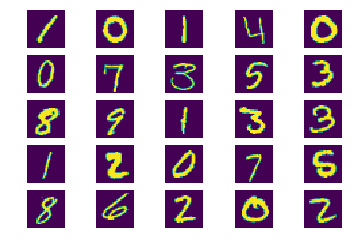

In [20]:
# Plotting several images
f, axarr = plt.subplots(5, 5)
k = 0;
for i in range(5):
    for j in range(5):
        axarr[i, j].imshow(train_images[k].reshape((28, 28)))
        axarr[i, j].axis('off')
        k += 1;
plt.show()

In [4]:
with tf.name_scope('input'):
    x = tf.placeholder(tf.float32, [None, 784], name='x-input')
    y_true = tf.placeholder(tf.float32, [None, 10], name='y-input')

### Custom batching

In [5]:
def next_batch(size, images, labels):
    idx = np.arange(0 , len(images))
    np.random.shuffle(idx)
    idx = idx[:size]
    images_shuffle = [images[i] for i in idx]
    labels_shuffle = [labels[i] for i in idx]

    return np.asarray(images_shuffle), np.asarray(labels_shuffle)

### Weight initialisation

In [6]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

### Convolution and Pooling

In [7]:
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

### First convolutional layer

The convolution will compute 32 features for each 5x5 patch.

Its weight tensor will have a shape of [5, 5, 1, 32].

The first two dimensions are the patch size, the next is the number of input channels,
and the last is the number of output channels.

We will also have a bias vector with a component for each output channel.

In [8]:
# reshaping x-image, 2:width, 3:height, 4:color channels
with tf.name_scope('reshape'):
    x_image = tf.reshape(x, [-1, 28, 28, 1])
    tf.summary.image('input', x_image, 10)

In [9]:
with tf.name_scope('conv1'):
    with tf.name_scope('weights'):
        W_conv1 = weight_variable([5, 5, 1, 32])
    with tf.name_scope('biases'):
        b_conv1 = bias_variable([32])

    # convolving, adding bias, applying relu
    with tf.name_scope('conv_bias'):
        c_conv1 = conv2d(x_image, W_conv1) + b_conv1
    with tf.name_scope('relu'):
        h_conv1 = tf.nn.relu(c_conv1)

### First pooling layer

In [10]:
with tf.name_scope('pool1'):
    h_pool1 = max_pool_2x2(h_conv1)

### Second convolutional layer

In [11]:
with tf.name_scope('conv2'):
    with tf.name_scope('weights'):
        W_conv2 = weight_variable([5, 5, 32, 64])
    with tf.name_scope('biases'):
        b_conv2 = bias_variable([64])
    with tf.name_scope('conv_bias'):
        c_conv2 = conv2d(h_pool1, W_conv2) + b_conv2
    with tf.name_scope('relu'):
        h_conv2 = tf.nn.relu(c_conv2)    

### Second pooling layer

In [12]:
with tf.name_scope('pool2'):
    h_pool2 = max_pool_2x2(h_conv2)

### Densely connected layer

In [13]:
# image size is now 7x7
# adding dense with 1024 neurons
with tf.name_scope('fc1'):
    W_fc1 = weight_variable([7 * 7 * 64, 1024])
    b_fc1 = bias_variable([1024])
    
    # reshape into a batch of vectors, multiply by weight matrix,
    # add a bias, apply relu
    h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
    h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

### Dropout

In [14]:
# placeholder for the probability that a neuron's output is kept during dropout
# to allow us to turn dropout on during training, and turn it off during testing
with tf.name_scope('dropout'):
    keep_prob = tf.placeholder(tf.float32)
    h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

### Readout layer

In [15]:
with tf.name_scope('fc2'):
    W_fc2 = weight_variable([1024, 10])
    b_fc2 = bias_variable([10])
    
    y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

## Training and Evaluation

The differences to tf-mnist-beginner are that:

    We will replace the steepest gradient descent optimizer with the more sophisticated ADAM optimizer.

    We will include the additional parameter keep_prob in feed_dict to control the dropout rate.

    We will add logging to every 100th iteration in the training process.


In [16]:
with tf.name_scope('loss'):
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=y_true, logits=y_conv)
    cross_entropy = tf.reduce_mean(cross_entropy)

with tf.name_scope('adam_optimizer'):
    train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
    
with tf.name_scope('accuracy'):
    correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_true, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



In [17]:
graph_location = "/tmp/tensorflow/mnist"
print('Saving graph to: %s' % graph_location)
train_writer = tf.summary.FileWriter(graph_location)
train_writer.add_graph(tf.get_default_graph())

Saving graph to: /tmp/tensorflow/mnist


In [18]:
# Training
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
for i in range(20000):
    batch = next_batch(50, train_images, train_labels.eval())
    if i % 100 == 0:
        train_accuracy = accuracy.eval(feed_dict={
            x: batch[0], y_true: batch[1], keep_prob: 1.0})
        #print('step %d, training accuracy %g' % (i, train_accuracy))
    train_step.run(feed_dict={x: batch[0], y_true: batch[1], keep_prob: 0.5})

In [19]:
# Evaluating on train data  
train_accuracies = []
for i in range(1000):
    train_batch = next_batch(50, train_images, train_labels.eval())
    train_accuracy = accuracy.eval(feed_dict={
                x: train_batch[0], y_true: train_batch[1], keep_prob: 1.0})
    train_accuracies.append(train_accuracy)
print('Accuracy on train set : ', tf.reduce_mean(train_accuracies).eval())

# Evaluating on validation data
valid_accuracies = []
for j in range(1000):
    valid_batch = next_batch(50, valid_images, valid_labels.eval())
    valid_accuracy = accuracy.eval(feed_dict={
                x: valid_batch[0], y_true: valid_batch[1], keep_prob: 1.0})
    valid_accuracies.append(valid_accuracy)
        # if j % 100 == 0:
            # print('step %d, validation accuracy %g' % (j, valid_accuracy))
print('Accuracy on validation set : ', tf.reduce_mean(valid_accuracies).eval())

Accuracy on train set :  0.99994
Accuracy on validation set :  0.98214
